In [227]:
import pandas as pd
import numpy as np

from IPython.display import display, HTML, display_html     # display output
pd.set_option('display.max_rows', 200)                      # display rows
pd.set_option('display.max_columns', 50)                    # display columns
pd.options.display.float_format = '{:.3f}'.format           # display 3 decimal point 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#My function
from util import *

#https://github.com/Jenniferz28/Time-Series-ARIMA-XGBOOST-RNN

In [228]:
# def bucket_avg(ts, bucket):
#     # ts is Sereis with index
#     # bucket =["30T","60T","M".....]
#     y = ts.resample(bucket).mean()
#     return y

In [229]:
# import data
df = pd.read_csv('./Data/inventory_split.csv', index_col=[0])
df['Document date'] = pd.to_datetime(df['Document date'])
df.sample(3)

,Actual Goods Issue Year Period,Sold-to party,Sold to Party Name,Customer Hierarchy,Ship-to party,Ship to Party Name,Location (City),Region,Region Name,Postal Code,Sales Org,Sales Org. Name,Distr Chan,Distr. Channel Name,Division,Division Name,Sales document,Document date,Plant,Plant Name,Postal Code.1,Location (City).1,Region.1,Region Plant Name,Del No.,Material,Description,Order qty,Gds mvt qty,Gross weight ord (Lb),Gross Weight Dlvrd (Lb),GSV Delivered,DD_week_num,DD_month,DD_year,DC,Parent Account,Priority,Correct_DC,approx_unit_lb
308904,2018P06,10198250,SUPER VALU WEST,SUPERVALU,10198475,SUPER VALU 12,BISMARCK,ND,North Dakota,58504,241,Mars US Food,10,Non Specific,51,Non Specific,5004375983,2018-05-16,USV2,Manteno IL DFC - Food,60950-9396,Manteno,IL,Illinois,5602041907,U0100803,UB CONVERTED BRAND RICE 18/2LB,18,18,704.772,704.772,1004.400,20,5,2018,USV2,SUPERVALU,6,True,39.154
7668,2017P01,10197635,WAL-MART (EXCL HAWAII),WALMART,10246399,WAL-MART DC 6068,SANGER,TX,Texas,76266,241,Mars US Food,10,Non Specific,51,Non Specific,5003717173,2017-01-18,USJ7,Greenville Truckload Whse-Food,38703,Greenville,MS,Mississippi,5600970970,U0323400,UB READY RICE GARDEN VEGETABLE 12/8.5OZ,126,126,931.141,931.140,2404.080,3,1,2017,USJ7,WALMART,1,True,7.390
450174,2019P01,10198459,KING SOOPERS (POI),KROGER,10198515,KING SOOPERS,AURORA,CO,Colorado,80011,241,Mars US Food,10,Non Specific,51,Non Specific,5004749624,2019-01-14,USJ7,Greenville Truckload Whse-Food,38703,Greenville,MS,Mississippi,5602637903,U3390500,UB WHOLE GRAIN BROWN BIB 12/14OZ,70,70,871.920,871.920,1579.200,3,1,2019,UV6,KROGER,4,False,12.456


In [230]:
# TopSKUs Descending order qty.
TopSKU = df.pivot_table(values='Order qty', index='Description', aggfunc = lambda x: x.sum()).sort_values(by='Order qty', ascending=False)

In [317]:
# Pivot: Order qty per Plant on SKU0
temp = df[df['Description'].isin([TopSKU.index[20]])].pivot_table(values='Order qty', index=['Document date'],columns='Plant',aggfunc = lambda x: x.sum()).fillna(0)

# To Ratios
temp = temp.loc[:,temp.columns].div(temp.sum(axis=1), axis=0)
temp = pd.DataFrame(temp.to_records()).set_index('Document date')
temp.head(3)

### I will have to make this into a function

,USC8,USD3,USE2,USJ7,USV2,USV6
Document date,,,,,,
2016-12-12,0.000,0.000,1.000,0.000,0.000,0.000
2016-12-16,0.000,0.000,0.000,1.000,0.000,0.000
2016-12-19,0.000,0.000,0.000,0.682,0.000,0.318


In [318]:
# TESTING USJ7 on SKU0
data = pd.DataFrame(temp.iloc[:,3].copy()) # Test USJ7
data.columns = ['y']                       # target
bucket_size="w"                       # by week
df1 = pd.DataFrame(bucket_avg(data.y,bucket_size))

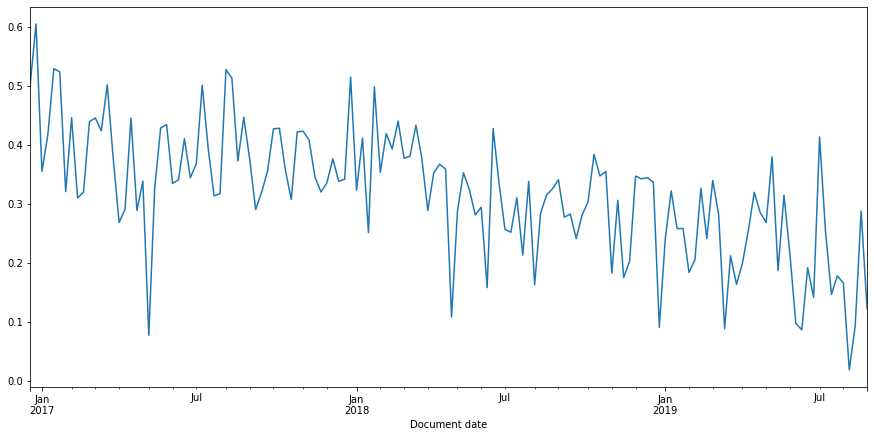

In [319]:
# PLOT
plt.figure(figsize = (15,7))
df1.y.plot()
plt.show()

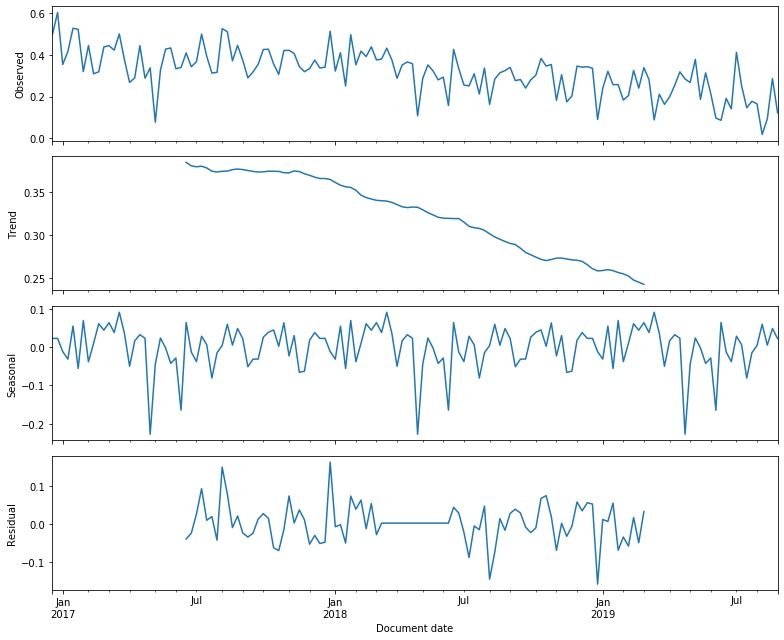

In [320]:
# component plot
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(df1.y, model='additive')
fig = decomposition.plot()
plt.tight_layout()
# plt.savefig( 'ts_decomposition_plot.png', dpi=300)
plt.show()

# Lags of time series
shifting the series **n** stemps backc we get a feature column wher ethe current value of timeseries is aligned with its value at the time **t-n**

In [321]:
df1 = pd.DataFrame(bucket_avg(data.y,bucket_size))

# adding the lag of the target variable from 4 steps back up to 12
for i in range(2,12):
    df1['lag_{}'.format(i)] = df1.y.shift(i)
    
display(df1)
# seperating target and features
y = df1.dropna().y
X = df1.dropna().drop(['y'], axis=1)

,y,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
Document date,,,,,,,,,,,
2016-12-18,0.500,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2016-12-25,0.605,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-01-01,0.355,0.500,nan,nan,nan,nan,nan,nan,nan,nan,nan
2017-01-08,0.417,0.605,0.500,nan,nan,nan,nan,nan,nan,nan,nan
2017-01-15,0.529,0.355,0.605,0.500,nan,nan,nan,nan,nan,nan,nan
2017-01-22,0.523,0.417,0.355,0.605,0.500,nan,nan,nan,nan,nan,nan
2017-01-29,0.321,0.529,0.417,0.355,0.605,0.500,nan,nan,nan,nan,nan
2017-02-05,0.446,0.523,0.529,0.417,0.355,0.605,0.500,nan,nan,nan,nan
2017-02-12,0.310,0.321,0.523,0.529,0.417,0.355,0.605,0.500,nan,nan,nan


In [322]:
X

,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
Document date,,,,,,,,,,
2017-03-05,0.320,0.310,0.446,0.321,0.523,0.529,0.417,0.355,0.605,0.500
2017-03-12,0.439,0.320,0.310,0.446,0.321,0.523,0.529,0.417,0.355,0.605
2017-03-19,0.445,0.439,0.320,0.310,0.446,0.321,0.523,0.529,0.417,0.355
2017-03-26,0.424,0.445,0.439,0.320,0.310,0.446,0.321,0.523,0.529,0.417
2017-04-02,0.501,0.424,0.445,0.439,0.320,0.310,0.446,0.321,0.523,0.529
2017-04-09,0.377,0.501,0.424,0.445,0.439,0.320,0.310,0.446,0.321,0.523
2017-04-16,0.268,0.377,0.501,0.424,0.445,0.439,0.320,0.310,0.446,0.321
2017-04-23,0.291,0.268,0.377,0.501,0.424,0.445,0.439,0.320,0.310,0.446
2017-04-30,0.445,0.291,0.268,0.377,0.501,0.424,0.445,0.439,0.320,0.310


In [323]:
# Error function (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [324]:
from sklearn.linear_model import LinearRegression            # linear model
from sklearn.model_selection import cross_val_score          # cv
from sklearn.model_selection import TimeSeriesSplit          # you have everything done for you

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

#------------------------------------------------------------------------------------------------
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
        test_size: percentage
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv = tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)  # model.coef_
    coefs.columns = ["coef"]
    
    #by taking absolute values and sort. then drop
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [325]:
# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)



In [326]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

cross_val_score(lr, X_train, y_train, 
                                    cv = tscv, 
                                    scoring="neg_mean_squared_error")

array([-0.01386461, -0.00366266, -0.00679365, -0.01855007, -0.0058416 ])

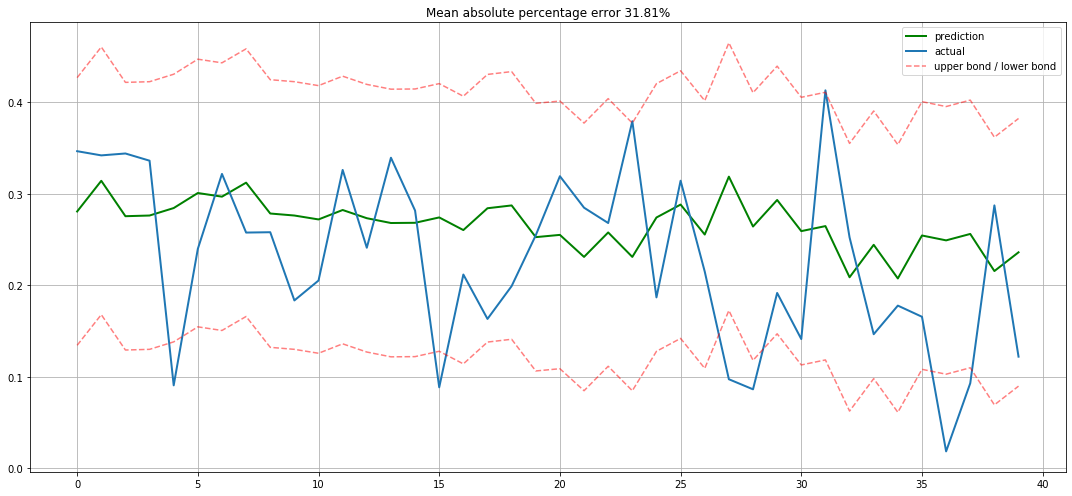

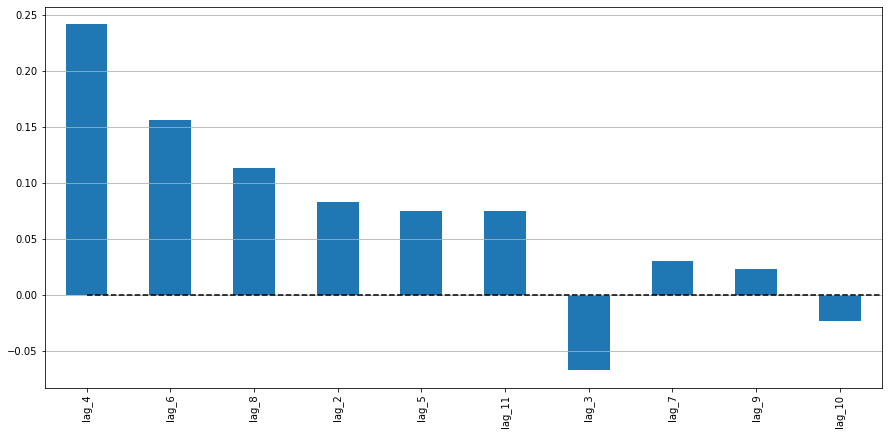

In [327]:
plotModelResults(lr, X_train, X_test, plot_intervals=True)
plotCoefficients(lr)

Engineered Features

In [328]:
# SKU0 on USJ7
temp = df[df['Description'].isin([TopSKU.index[20]])]
temp = temp[temp['Plant']=='USJ7']

# feature1: DO_count per week
DO_count = temp.pivot_table(values='Del No.', index='Document date', aggfunc = lambda x: x.count())
DO_count = pd.DataFrame(bucket(DO_count['Del No.'], bucket_size, 'sum'))

# feature2: weight 
weight = temp.pivot_table(values='Gross weight ord (Lb)', index='Document date', aggfunc = lambda x: x.sum())
weight = pd.DataFrame(bucket(weight['Gross weight ord (Lb)'], bucket_size, 'sum'))

# feature3: order qty
qty = temp.pivot_table(values='Order qty', index='Document date', aggfunc = lambda x: x.sum())
qty = pd.DataFrame(bucket(qty['Order qty'], bucket_size, 'sum'))

# feature4: correctDC
correct = temp.pivot_table(values='Correct_DC', index='Document date', aggfunc = lambda x: x.sum())
correct = pd.DataFrame(bucket(correct['Correct_DC'], bucket_size, 'mean'))

In [329]:
df1['DO_count'] = DO_count['Del No.']
df1['weight'] = weight['Gross weight ord (Lb)']
df1['total_qty'] = qty['Order qty']
df1['correct'] = correct['Correct_DC']


make sure to scale after adding different features

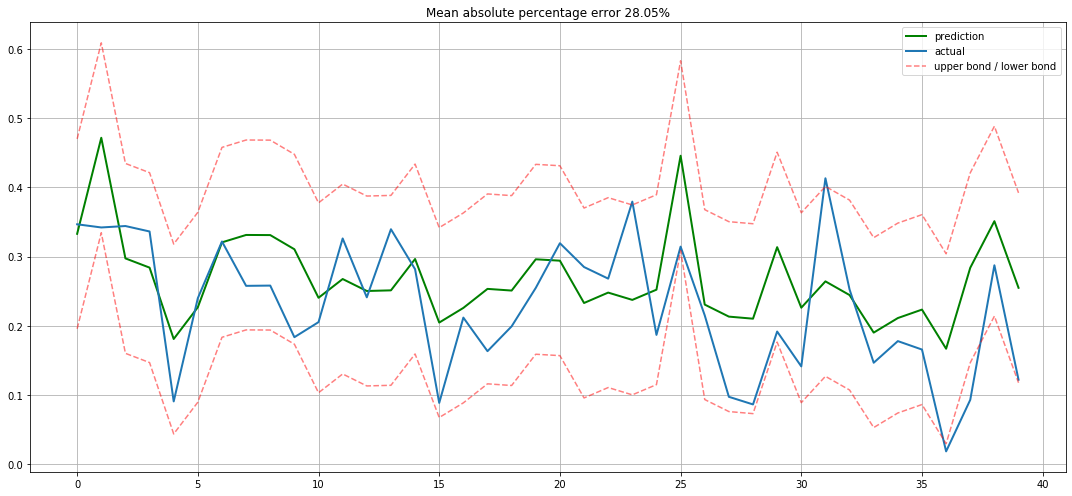

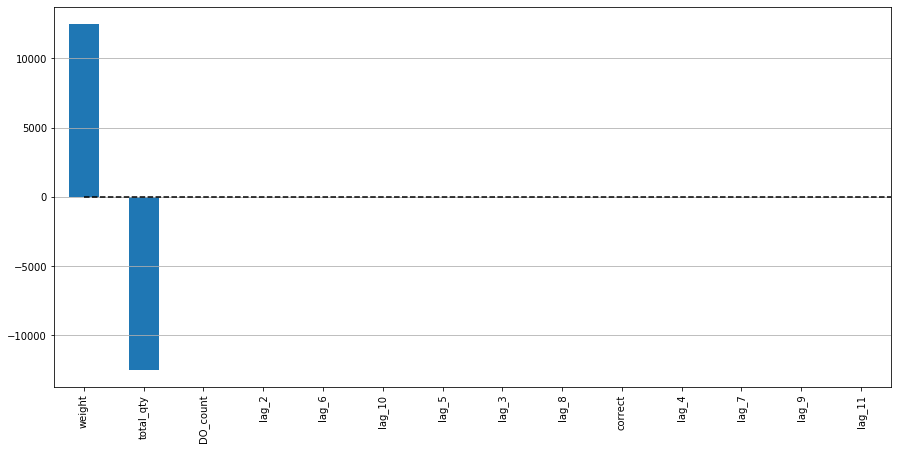

In [330]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
mmscaler = MinMaxScaler()
rscaler = RobustScaler()

y = df1.dropna().y
X = df1.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [331]:
len(X_test_scaled)

40

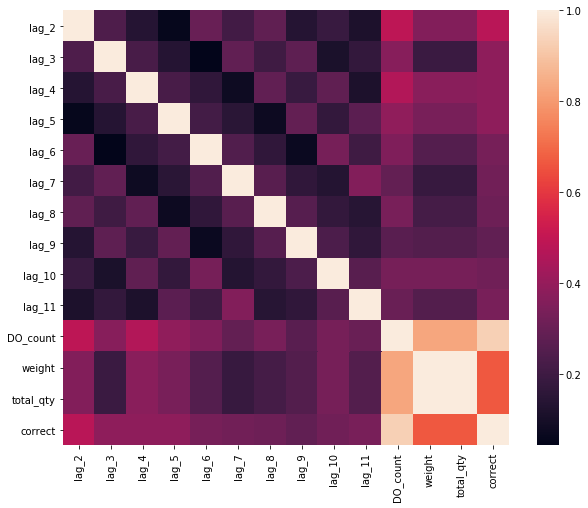

In [332]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr())
plt.show();

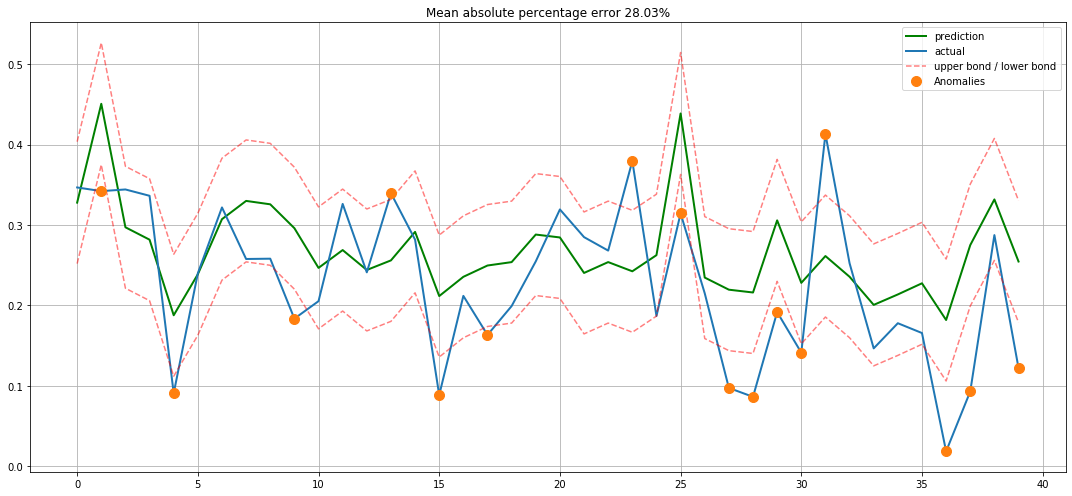

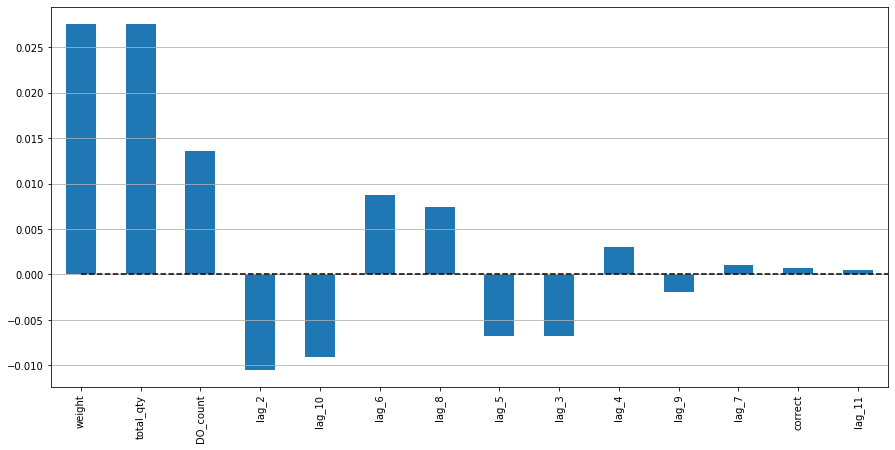

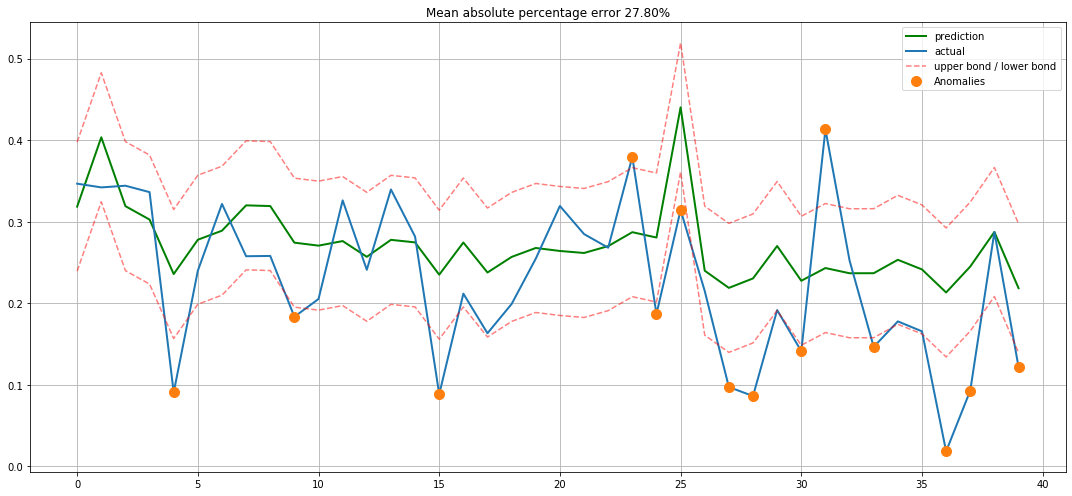

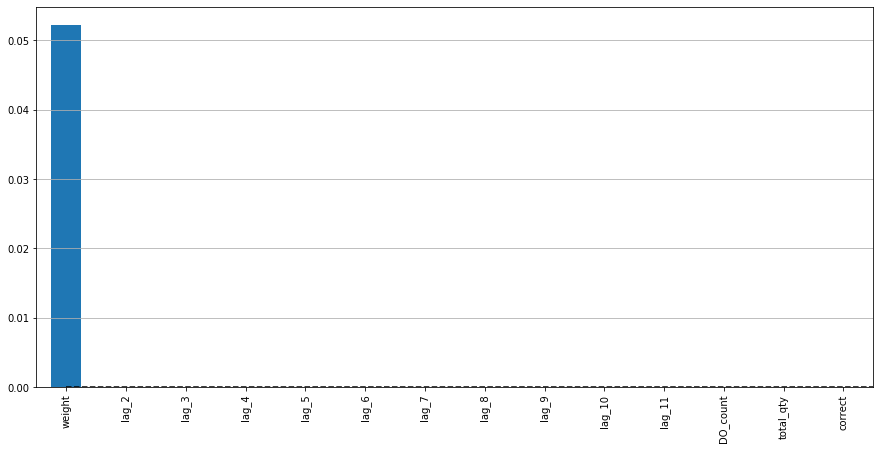

In [333]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge,
                X_train = X_train_scaled,
                X_test = X_test_scaled,
                plot_intervals=True,
                plot_anomalies=True)

plotCoefficients(ridge)


lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso,
                X_train = X_train_scaled,
                X_test = X_test_scaled,
                plot_intervals=True,
                plot_anomalies=True)

plotCoefficients(lasso)

In [334]:
- interval time 
- freeze time:: 2WK
- hold out set: prameter 2 WKs out advanced.
- update the prediction interval == update interval.
- predictions for 1 day in adanced.


SyntaxError: invalid syntax (<ipython-input-334-ffc49a020c63>, line 1)

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective ='reg:squarederror')
xgb.fit(X_train_scaled, y_train)

plotModelResults(xgb,
                X_train=X_train_scaled,
                X_test=X_test_scaled,
                plot_intervals=True,
                plot_anomalies=True)

In [ ]:
xgb.predict(X_test_scaled)

# ElasticNet

# Tuning on Regularization

# Feature Engineering

In [161]:
# SKU0 on USJ7
temp = df[df['Description'].isin([TopSKU.index[0]])]
temp = temp[temp['Plant']=='USJ7']

# feature1: DO_count per week
DO_count = temp.pivot_table(values='Del No.', index='Document date', aggfunc = lambda x: x.count())
DO_count = pd.DataFrame(bucket(DO_count['Del No.'], bucket_size, 'sum'))

# feature2: weight 
weight = temp.pivot_table(values='Gross weight ord (Lb)', index='Document date', aggfunc = lambda x: x.sum())
weight = pd.DataFrame(bucket(weight['Gross weight ord (Lb)'], bucket_size, 'sum'))

# feature3: order qty
qty = temp.pivot_table(values='Order qty', index='Document date', aggfunc = lambda x: x.sum())
qty = pd.DataFrame(bucket(qty['Order qty'], bucket_size, 'sum'))

# feature4: correctDC
correct = temp.pivot_table(values='Correct_DC', index='Document date', aggfunc = lambda x: x.sum())
correct = pd.DataFrame(bucket(correct['Correct_DC'], bucket_size, 'mean'))

TypeError: unsupported operand type(s) for ^: 'float' and 'int'

In [21]:
correct

,Correct_DC
Document date,
2016-12-11,0.000
2016-12-18,0.000
2016-12-25,0.000
2017-01-01,2.000
2017-01-08,7.000
2017-01-15,6.333
2017-01-22,6.000
2017-01-29,9.500
2017-02-05,7.200


In [46]:
temp.pivot_table(values='Order qty', index='Ship to Party Name', aggfunc = lambda x: x.sum()).sort_values(by='Order qty', ascending=False).stack().reset_index(level=1)

,level_1,0
Ship to Party Name,,
PUBLIX SUPER MARKETS,Order qty,98532
H E BUTT GROC CO,Order qty,96369
PEYTONS NORTH,Order qty,78899
KING SOOPERS,Order qty,61488
FOOD LION/DELHAIZE AMERICA DC7,Order qty,57153
RALPHS GROCERY CO,Order qty,42781
DEMOULAS SUPERMARKET,Order qty,32424
WAL-MART DC 6020,Order qty,27770
PUBLIX LAKELAND DRY GROCERY (4101),Order qty,26628


In [13]:
df.pivot_table(values='Order qty', index=['Document date'],columns='Plant',aggfunc = lambda x: x.sum()).fillna(0)

Plant,USC8,USD3,USE2,USJ7,USV2,USV6
Document date,,,,,,
2016-08-25,0.0,0.0,0.0,336.0,0.0,0.0
2016-08-26,0.0,0.0,0.0,2352.0,0.0,0.0
2016-08-28,0.0,0.0,0.0,336.0,0.0,0.0
2016-08-29,0.0,0.0,0.0,0.0,336.0,0.0
2016-10-06,336.0,0.0,0.0,0.0,0.0,0.0
2016-10-07,0.0,0.0,0.0,0.0,1008.0,336.0
2016-10-10,0.0,0.0,672.0,0.0,0.0,0.0
2016-10-11,336.0,0.0,0.0,0.0,0.0,0.0
2016-10-12,336.0,0.0,0.0,0.0,0.0,0.0
